# Project utilizing Facebook Prophet for prediction of company's daily future sales.

#####  Summary: Development of a model that  can predict future daily sales of a company based on past sales data using Facebook Prophet. The project is organised as follows: (a) Exploratory data analysis and data proccessing, (b) development of a Facebook Prophet model predicting future sales.

Introduction:
* For companies to become competitive and skyrocket their growth, they need to leverage AI/ML to develop predictive sales in the future.
* Predictive models attempt to forecast future sales based on historical data while taking into accoumt seasonality effects, demand, holidays, promotions, and competition.

### In this project consulting will be give in the sales team of a company named Rossman. Their sales team provided data from 1115 of their stores with the objective of predicting future daily sales.

## 0. Import the required libraries and read the data set.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from fbprophet import Prophet

(a) Sales data

In [3]:
sales_train_df=pd.read_csv("train.csv")

C:\Users\Tam\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
sales_train_df.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
sales_train_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [6]:
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


**Data Dictionary:**
* Store: unique store Id
* Sales: sales/day, this is the target variable 
* Customers: number of customers on a given day
* Open: Boolean to say whether a store is open or closed (0 = closed, 1 = open)
* Promo: describes if store is running a promo on that day or not
* StateHoliday: indicate which state holiday (a = public holiday, b = Easter holiday, c = Christmas, 0 = None)
* SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools


(b) Store information Data

In [7]:
store_info_df=pd.read_csv("store.csv")

In [8]:
store_info_df.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [9]:
store_info_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [10]:
store_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


**Data Dictionary:**
* Store: unique store Id
* StoreType: categorical variable to indicate type of store (a, b, c, d)
* Assortment: describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance (meters): distance to closest competitor store
* CompetitionOpenSince [Month/Year]: provides an estimate of the date when competition was open
* Promo2: Promo2 is a continuing and consecutive promotion for some stores (0 = store is not participating, 1 = store is participating)
* Promo2Since [Year/Week]: date when the store started participating in Promo2
* PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## 1. Data processing, exploratory data analysis and visualization

### (a) Explore the sales data set

#### (i)Check for missing data

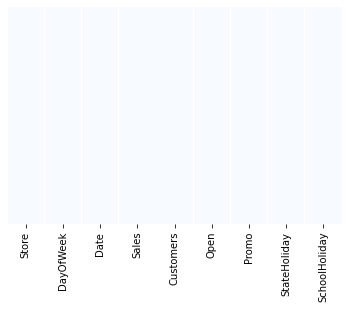

In [11]:
sns.heatmap(sales_train_df.isnull(),yticklabels=False, cbar=False,cmap='Blues')

**Comment:**
Luckily we don't have any missing data in this dataset.

#### (ii) Plot histograms with relating features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A511176E50>,
      dtype=object)

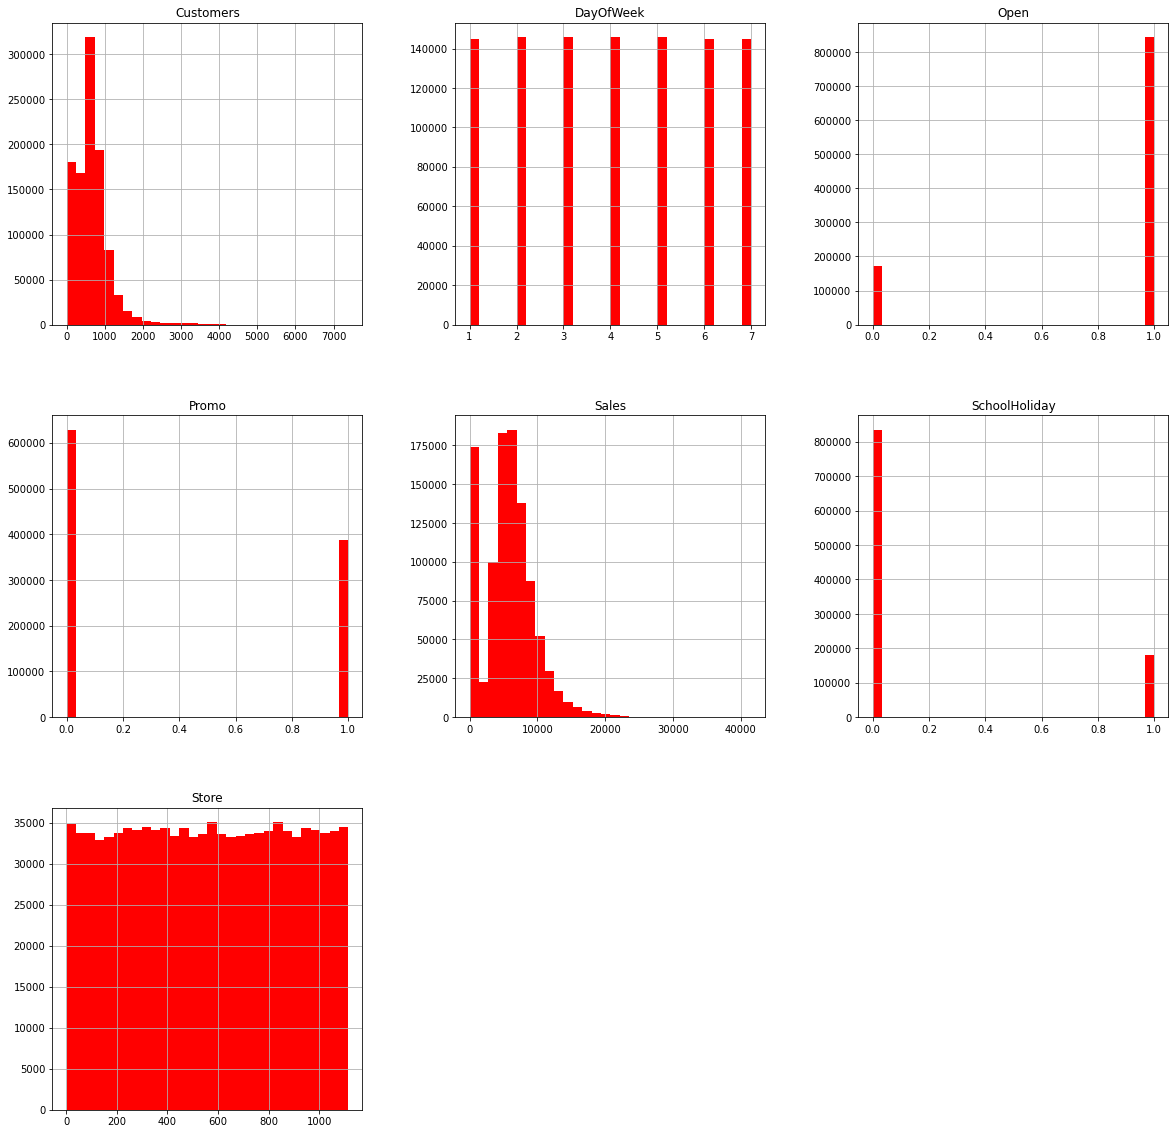

In [12]:
sales_train_df.hist(bins=30, figsize=(20,20),color='r')

**Comments:**
* Average 600 customers per day, maximum is 4500 (note that we can't see the outlier at 7388!)
* Data is equally distibuted across various Days of the week (~150000 observations x 7 day = ~1.1 million observation) 
* Stores are open ~80% of the time
* Data is equally distributed among all stores (no bias)
* Promo #1 was running ~40% of the time 
* Average sales around 5000-6000 Euros
* School holidays are around ~18% of the time

#### (iii) Check how many stores are open and how many are closed.

In [13]:
open_train_df=sales_train_df[sales_train_df['Open']==1]
closed_train_df=sales_train_df[sales_train_df['Open']==0]

In [14]:
print('Total=',len(sales_train_df))
print('Number of closed stores=',len(closed_train_df))
print('Number of open stores=',len(open_train_df))

Total= 1017209
Number of closed stores= 172817
Number of open stores= 844392


#### (iv) Keep only the open store and drop the 'Open' Column to simplify the dataset

In [15]:
sales_train_df=sales_train_df[sales_train_df['Open']==1]
sales_train_df.drop(['Open'],axis=1 , inplace=True)
sales_train_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1
...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,0,a,1
1016827,733,2,2013-01-01,10765,2377,0,a,1
1016863,769,2,2013-01-01,5035,1248,0,a,1
1017042,948,2,2013-01-01,4491,1039,0,a,1


In [16]:
sales_train_df.describe()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,0.446352,0.193580
std,321.731914,1.723689,3104.214680,401.227674,0.497114,0.395103
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000


**Comment:** The average number of sales (6955 euro) and the average number of customers (762) went up after we kept only the open stores of the dataset.

### (b) Explore the stores information data set

#### (i) Check for missing data

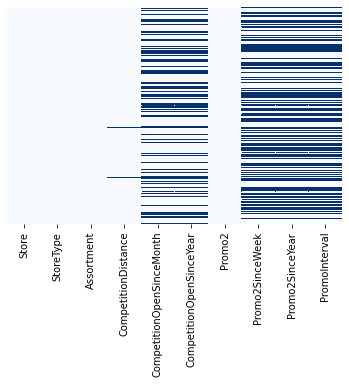

In [17]:
sns.heatmap(store_info_df.isnull(),yticklabels=False, cbar=False, cmap='Blues')

#### (ii) Replace the Promo and CompetetionOpenSince null values with 0

In [18]:
str_cols=['Promo2SinceWeek','Promo2SinceYear','PromoInterval','CompetitionOpenSinceYear','CompetitionOpenSinceMonth']

In [19]:
for str in str_cols:
  store_info_df[str].fillna(0, inplace=True)

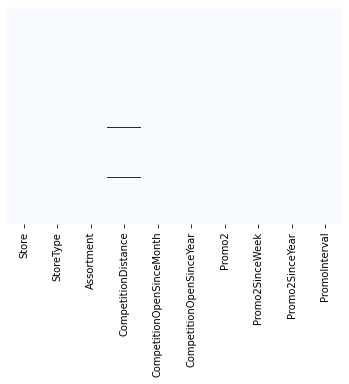

In [20]:
sns.heatmap(store_info_df.isnull(),yticklabels=False, cbar=False, cmap='Blues')

#### (iii) Replace the CompetitionDistance values with the Competition distance mean value

In [21]:
store_info_df['CompetitionDistance'].fillna(store_info_df['CompetitionDistance'].mean(),inplace=True)

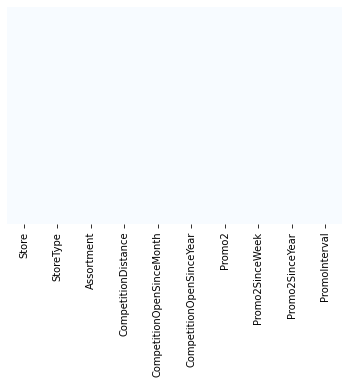

In [22]:
sns.heatmap(store_info_df.isnull(),yticklabels=False, cbar=False, cmap='Blues')

**Comment:** Now there is no missing values in our dataset anymore.

#### (iv) Plot histograms with relating features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A5105E6DC0>,
      dtype=object)

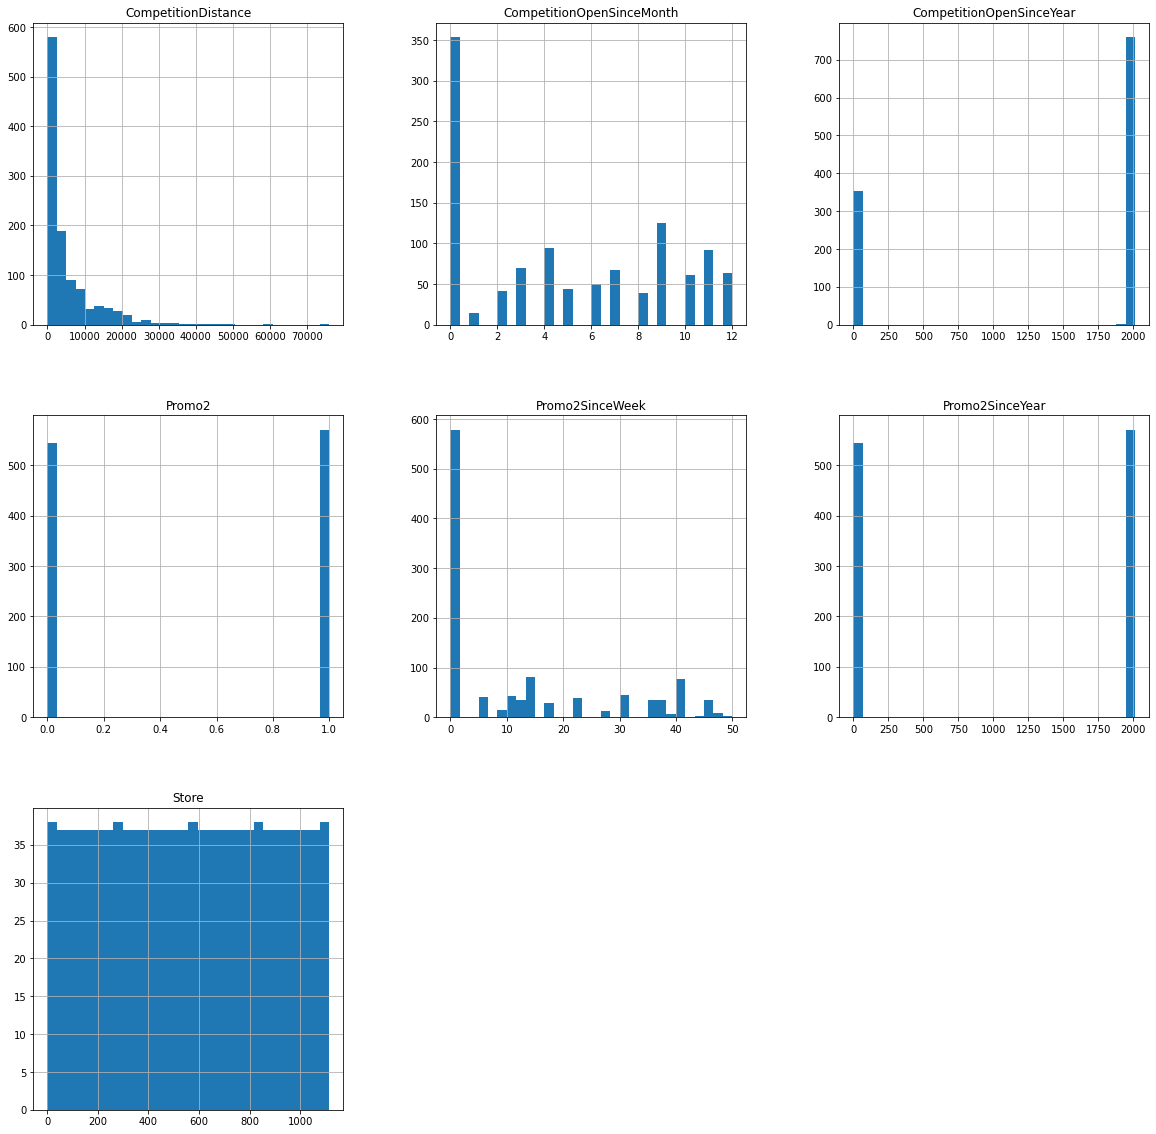

In [23]:
store_info_df.hist(bins=30,figsize=(20,20))

### (c) Explore merged data set

#### (i) Merge the dataset

In [24]:
sales_train_all_df=pd.merge(sales_train_df,store_info_df, how='inner',on='Store')
sales_train_all_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,292,1,2013-01-07,9291,1002,1,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844388,292,6,2013-01-05,2748,340,0,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844389,292,5,2013-01-04,4202,560,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844390,292,4,2013-01-03,4580,662,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0


#### (ii) Explore correlations

In [25]:
correlations=sales_train_all_df.corr()['Sales'].sort_values()
correlations

DayOfWeek                   -0.178736
Promo2SinceYear             -0.127621
Promo2                      -0.127596
Promo2SinceWeek             -0.058476
CompetitionDistance         -0.036343
CompetitionOpenSinceMonth   -0.018370
CompetitionOpenSinceYear     0.005266
Store                        0.007710
SchoolHoliday                0.038617
Promo                        0.368145
Customers                    0.823597
Sales                        1.000000
Name: Sales, dtype: float64

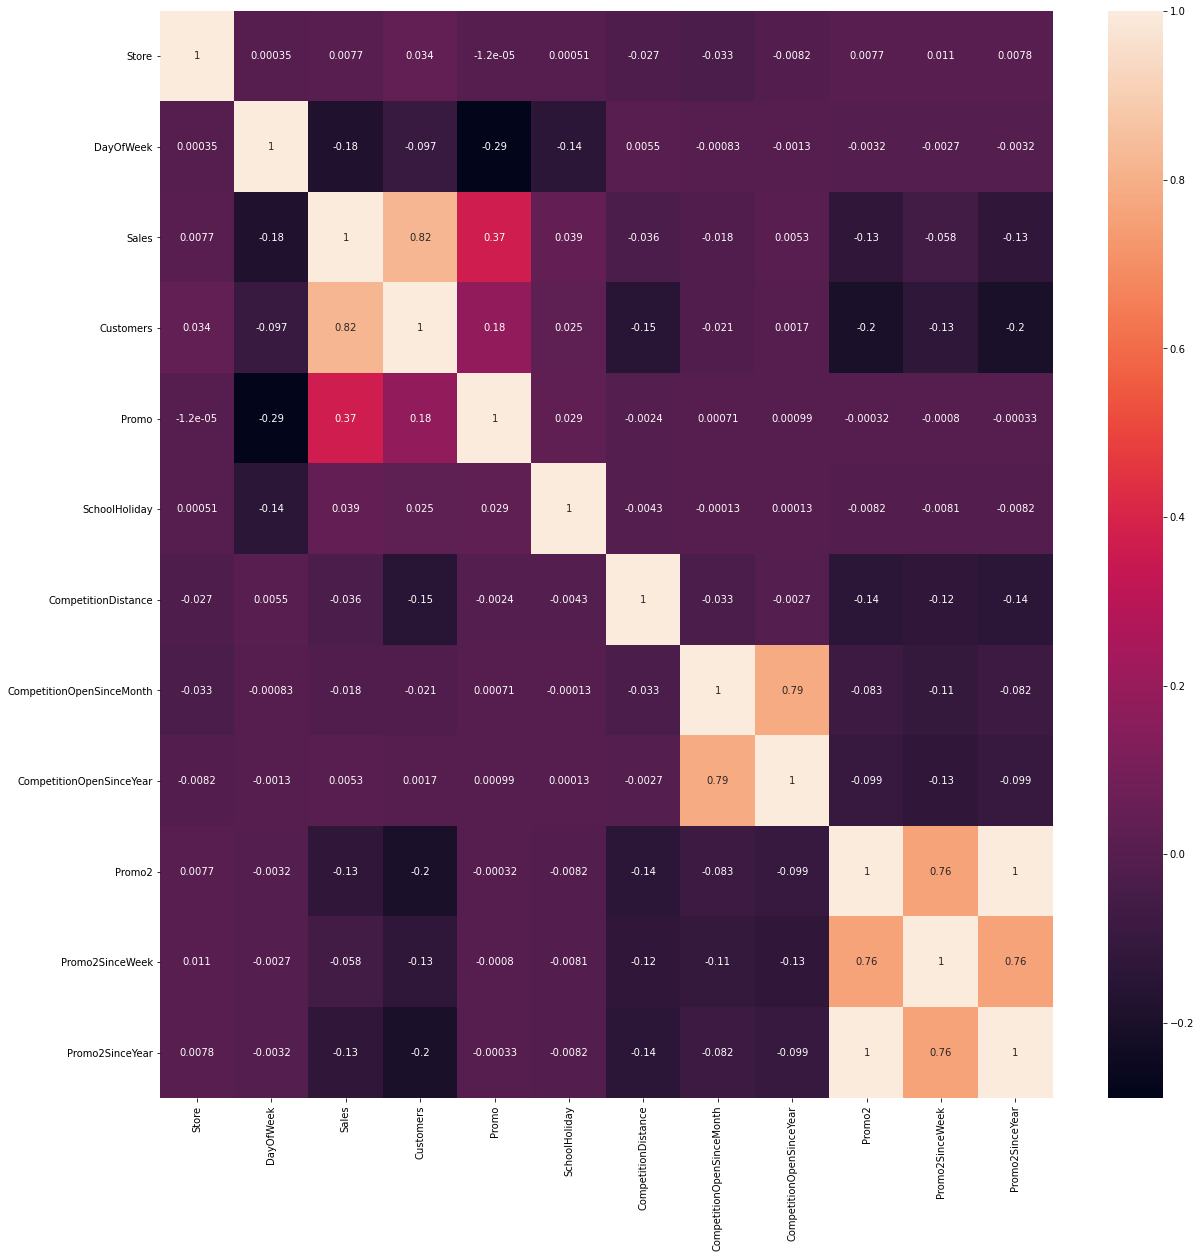

In [26]:
correlations = sales_train_all_df.corr()
f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(correlations, annot = True)

**Comments:**
* Customers and promo are positively correlated with the sales
* Promo2 does not seem to be effective at all

### (d) Data proccessing

#### (i) Seperation of Year,Date and Month into different columns

In [27]:
sales_train_all_df['Year'] = pd.DatetimeIndex(sales_train_all_df['Date']).year
sales_train_all_df['Month'] = pd.DatetimeIndex(sales_train_all_df['Date']).month
sales_train_all_df['Day'] = pd.DatetimeIndex(sales_train_all_df['Date']).day

In [28]:
sales_train_all_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,292,1,2013-01-07,9291,1002,1,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,7
844388,292,6,2013-01-05,2748,340,0,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,5
844389,292,5,2013-01-04,4202,560,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,4
844390,292,4,2013-01-03,4580,662,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,3


### (e) Data visualization

#### (i) Average sales and number of customers per month

Text(0.5, 1.0, 'Average Customers Per Month')

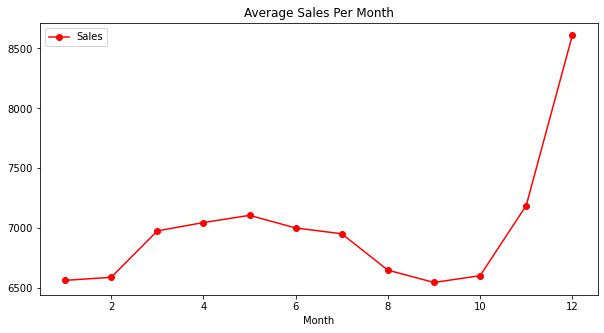

<Figure size 432x288 with 0 Axes>

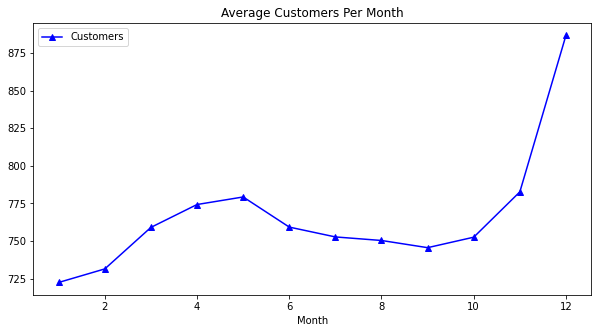

In [29]:
axis = sales_train_all_df.groupby('Month')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Average Sales Per Month')

plt.figure()
axis = sales_train_all_df.groupby('Month')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
axis.set_title('Average Customers Per Month')

**Comment:** It seems that the most profitable month is December

#### (ii) Sales and customers per day of the month 

Text(0.5, 1.0, 'Average Sales Per Day')

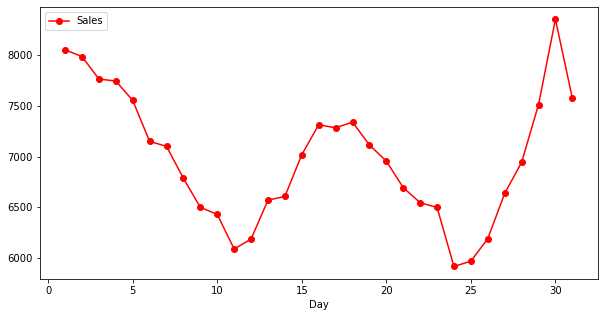

<Figure size 432x288 with 0 Axes>

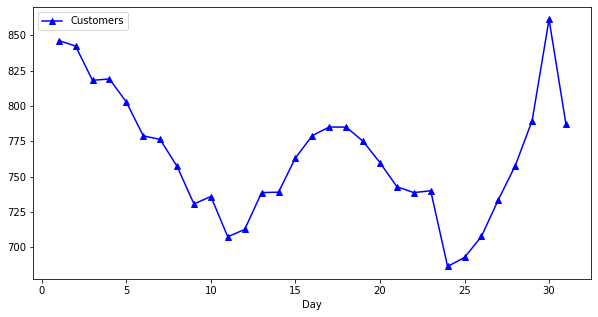

In [30]:
ax = sales_train_all_df.groupby('Day')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Average Sales Per Day')

plt.figure()
ax = sales_train_all_df.groupby('Day')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
axis.set_title('Average Sales Per Day')

**Comment:** It seems that the number of sales and customer increase towards the begging and the ending of each month.

#### (iii) Sales and customers per day of the week

Text(0.5, 1.0, 'Average Customers Per Day of the Week')

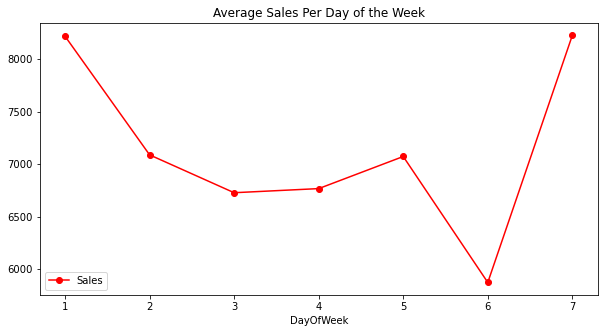

<Figure size 432x288 with 0 Axes>

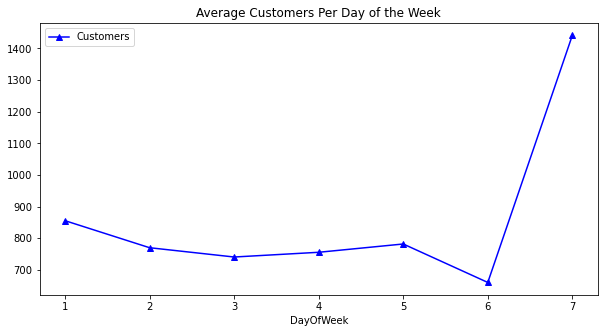

In [31]:
axis = sales_train_all_df.groupby('DayOfWeek')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Average Sales Per Day of the Week')

plt.figure()
axis = sales_train_all_df.groupby('DayOfWeek')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
axis.set_title('Average Customers Per Day of the Week')


**Comment:** It seems that the days with the most Sales are Sunday and Monday while the greatest amount of customers visit the stores on Sundays.

#### (iv) Store type comparison

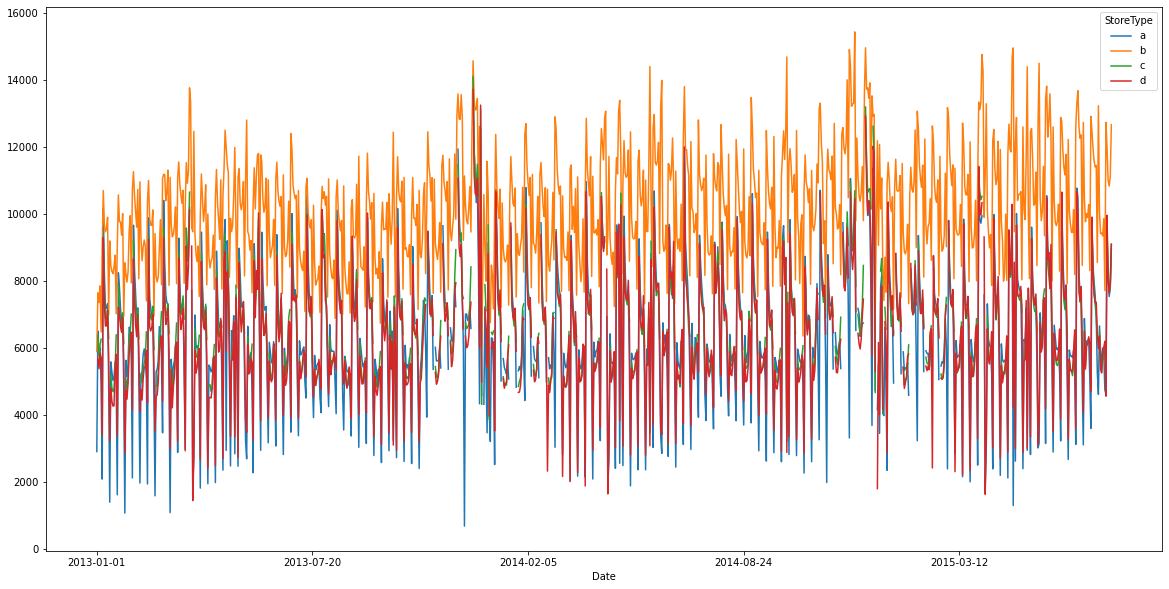

In [32]:
fig, ax = plt.subplots(figsize=(20,10))
sales_train_all_df.groupby(['Date','StoreType']).mean()['Sales'].unstack().plot(ax=ax)

**Comment:** It seems that the 'b' store type has the greatest amount of sales through the recorded time while the 'a' store type has the lowest.

#### (v) Check the effectiveness of promos

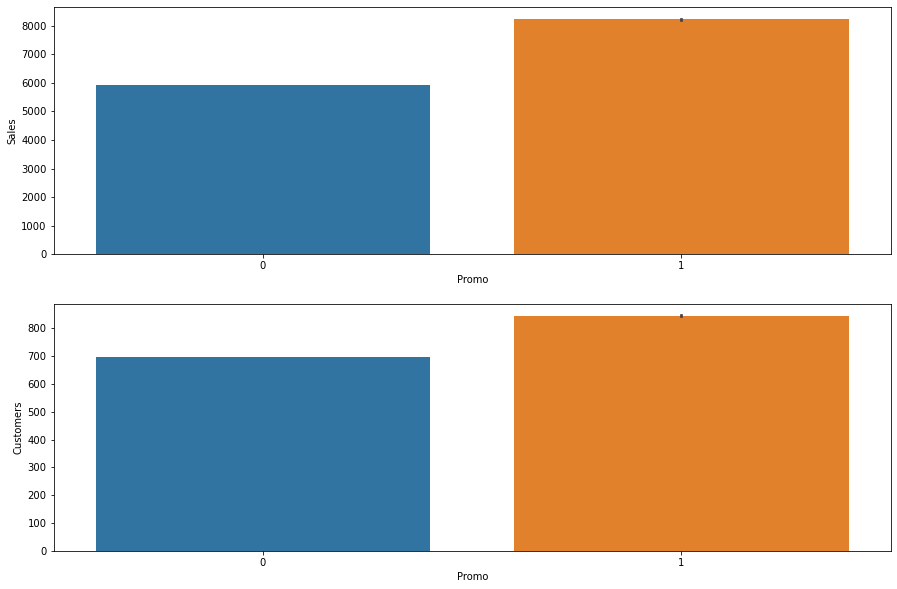

In [33]:
plt.figure(figsize=[15,10])

plt.subplot(211)
sns.barplot(x = 'Promo', y = 'Sales', data = sales_train_all_df)

plt.subplot(212)
sns.barplot(x = 'Promo', y = 'Customers', data = sales_train_all_df)

**Comment:** It seems that the amount of sales and the number of customers increase during the promo periods

## 2. Forecasting with Facebook Prophet

### (a) Training the model without taking into account the Holidays effect

#### (i) Development of the function that trains the forecast model

**Comment:** The function takes in the dataframe, storeID, and number of future period forecast. Then it generates date/sales columns in Prophet format and finally it makes time series predictions.

In [34]:
def sales_predictions(Store_ID, sales_df, periods):

  sales_df=sales_df[sales_df['Store']==Store_ID]
  sales_df=sales_df[['Date','Sales']].rename(columns={'Date':'ds','Sales':'y'})
  sales_df=sales_df.sort_values('ds')

  model=Prophet()
  model.fit(sales_df)
  future=model.make_future_dataframe(periods=periods)
  forecast=model.predict(future)
  figure=model.plot(forecast,xlabel='Data',ylabel='Sales')
  figure2=model.plot_components(forecast)

  
  return sales_df

#### (ii) Example for predicting the daily sales forecast over the next 60 days for the store with id=10

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,y
7819,2013-01-02,4812
7818,2013-01-03,4675
7817,2013-01-04,5114
7816,2013-01-05,4256
7815,2013-01-07,7804
...,...,...
7040,2015-07-27,7212
7039,2015-07-28,6140
7038,2015-07-29,5524
7037,2015-07-30,6186


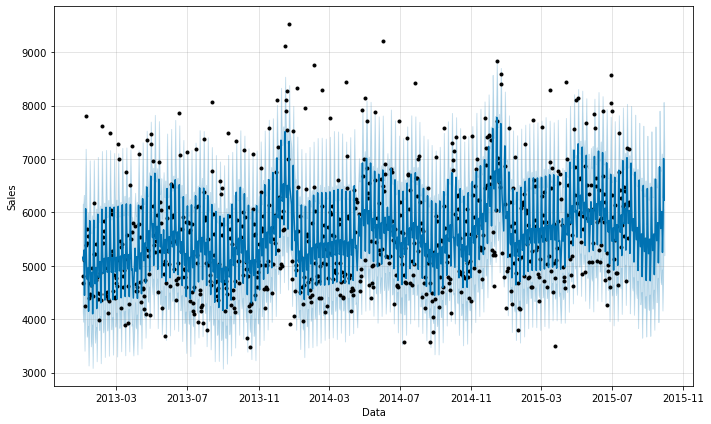

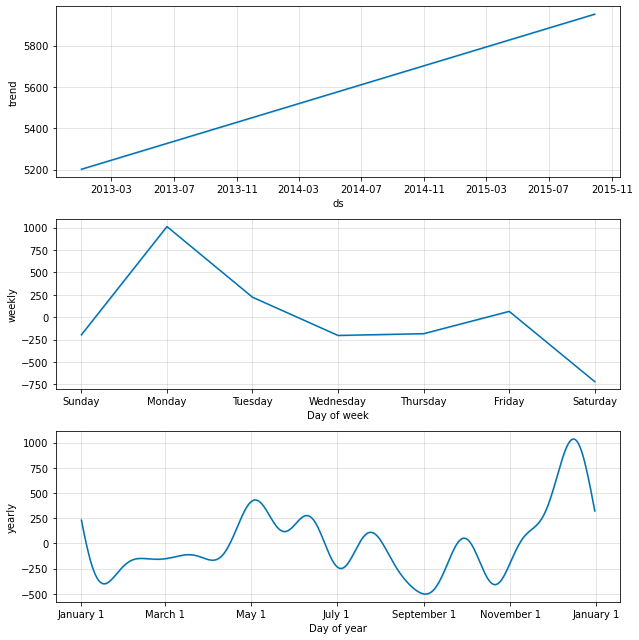

In [35]:
sales_predictions(10,sales_train_all_df,60)

**Comments:**
* In the first figure it is depicted the daily sales prediction over the next 60 days. The prediction was done by developing a trend using past data (black bullets). In addition, with the different shades of blue in the figure it is depicted the level of confidence for this prediction. 
* In the second figure it is depicted the general trend of sales.
* In the third figure it is depicted the trend for day of week.
* In the fourth figure it is depicted the trend for day of year.

### (b) Training the model by taking into account the Holidays effect


#### (i)Development of the function that trains the forecast model


**Comment:** The function takes in the dataframe, storeID, holidays and number of future period forecast. Then it generates date/sales columns in Prophet format and finally it makes time series predictions.

In [37]:
def sales_prediction(Store_ID, sales_df, holidays, periods):
  # Function that takes in the storeID and returns two date/sales columns in Prophet format
  # Format data to fit prophet 

  sales_df = sales_df[ sales_df['Store'] == Store_ID ]
  sales_df = sales_df[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales':'y'})
  sales_df = sales_df.sort_values('ds')
  
  model    = Prophet(holidays = holidays)
  model.fit(sales_df)
  future   = model.make_future_dataframe(periods = periods)
  forecast = model.predict(future)
  figure   = model.plot(forecast, xlabel='Date', ylabel='Sales')
  figure2  = model.plot_components(forecast)

#### (ii) Data processing to fit the model's needs (creating holidays dataframe)

In [38]:
school_holidays = sales_train_all_df[sales_train_all_df['SchoolHoliday'] == 1].loc[:, 'Date'].values
state_holidays = sales_train_all_df [ (sales_train_all_df['StateHoliday'] == 'a') | (sales_train_all_df['StateHoliday'] == 'b') | (sales_train_all_df['StateHoliday'] == 'c')  ].loc[:, 'Date'].values

In [40]:
state_holidays = pd.DataFrame({'ds': pd.to_datetime(state_holidays),
                               'holiday': 'state_holiday'})

In [41]:
school_holidays = pd.DataFrame({'ds': pd.to_datetime(school_holidays),
                                'holiday': 'school_holiday'})

In [44]:
school_state_holidays = pd.concat((state_holidays, school_holidays))

#### (iii) Example for predicting the daily sales forecast over the next 60 days for the store with id=10

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


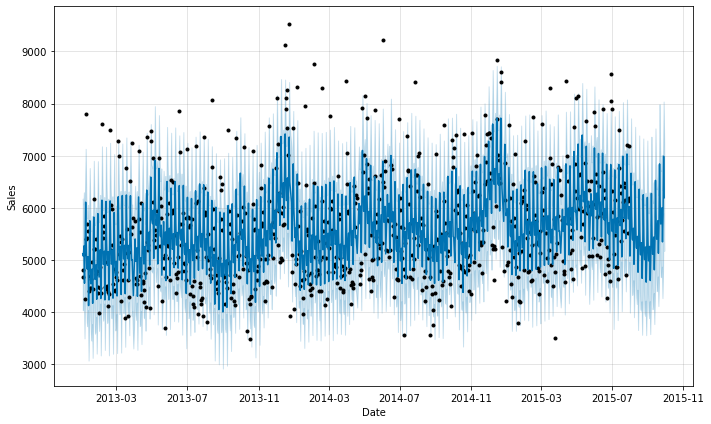

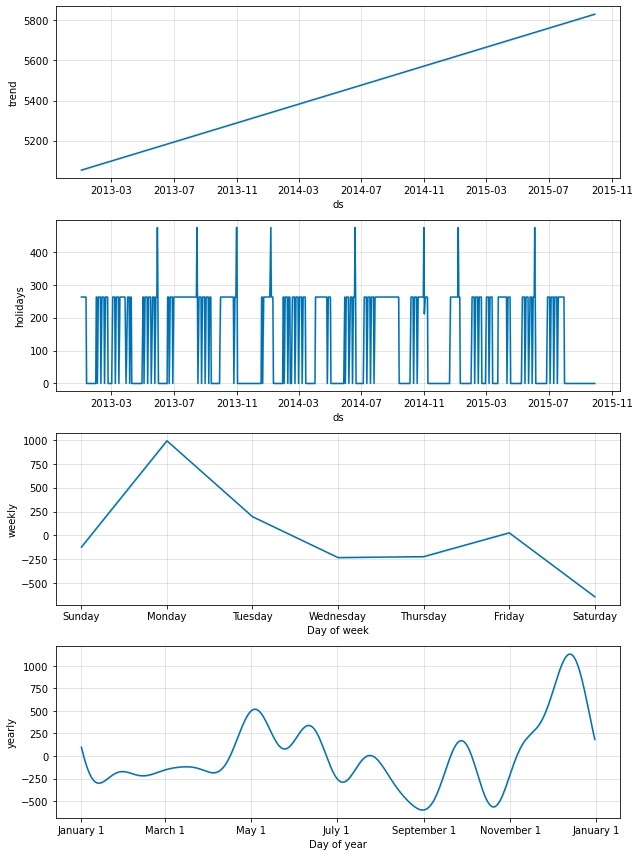

In [45]:
sales_prediction(10, sales_train_all_df, school_state_holidays, 60)

**Comments:**
* In the first figure it is depicted the daily sales prediction over the next 60 days. The prediction was done by developing a trend using past data (black bullets). In addition, with the different shades of blue in the figure it is depicted the level of confidence for this prediction. 
* In the second figure it is depicted the general trend of sales.
* In the third figure it is depicted the "spikes" associated with the holdays.
* In the fourth figure it is depicted the trend for day of week.
* In the fifth figure it is depicted the trend for day of year.